In [12]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [14]:
link = 'https://drive.google.com/open?id=1uBkTIkkDhjaIJSoTVny6yrZWdGLGXZPq'

In [ ]:
fluff, id = link.split('=')
print (id) 

In [17]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('WaterQualityData.csv')  
df3 = pd.read_csv('WaterQualityData.csv')

In [18]:
import pandas as pd
WQI_parameters = pd.read_csv('WaterQualityData.csv')
df = pd.DataFrame(WQI_parameters, columns=["pH","TN","BOD5","TP","NH3+","COD", "Iron", "Copper", "Zinc","DO","TDS","Ca","Mg","Na","Cl-","HCO", "SO4", "PO4","Cr"])
print (df)

        pH    TN  BOD5    TP  NH3+  ...      Cl-  HCO  SO4   PO4    Cr
0     8.31  0.87  6.24  0.69  5.44  ...  3801.28  NaN  NaN  1.64  0.14
1     8.01  6.38  2.90  0.20  0.38  ...  7774.27  NaN  NaN  0.92  0.15
2     7.99  5.92  3.18  0.06  8.32  ...  3215.93  NaN  NaN  1.48  0.04
3     8.41  0.64  2.88  0.31  3.78  ...  8464.36  NaN  NaN  0.08  0.09
4     8.39  0.95  6.50  0.37  0.61  ...  5962.02  NaN  NaN  1.17  0.07
...    ...   ...   ...   ...   ...  ...      ...  ...  ...   ...   ...
4995  7.79  0.37  7.35  0.59  2.19  ...  4612.34  NaN  NaN  1.04  0.03
4996  8.16  2.00  5.89  0.12  2.09  ...   814.82  NaN  NaN  0.74  0.11
4997  7.71  2.63  2.83  0.97  0.75  ...  4234.54  NaN  NaN  1.59  0.10
4998  8.06  3.54  2.58  0.07  6.20  ...  7671.92  NaN  NaN  0.34  0.06
4999  7.93  0.84  3.19  0.50  9.12  ...  5498.40  NaN  NaN  1.50  0.01

[5000 rows x 19 columns]


In [19]:
df = df.fillna(0)

In [20]:
import numpy as np
W = np.array([0.072, 0.054, 0.091, 0.054, 0.054, 0.072, 0.018, 0.018, 0.036, 0.018, 0.018, 0.036, 0.036, 0.036, 0.054, 0.054, 0.072, 0.091, 0.018])
S = np.array([7.65, 0.50, 3.00, 0.10, 0.50, 15.00, 0.30, 1.00, 1.00, 6.00, 450.00, 300.00, 30.00, 200.00, 250.00, 1, 250.00, 50.00, 0.05])
df_y = pd.DataFrame(columns=['WQI'])
for index, row in df.iterrows():
  	C = np.array(row)
  	Q = (C / S) * 100
  	SI = W * Q
  	df_y.loc[index] = [np.sum(SI)]

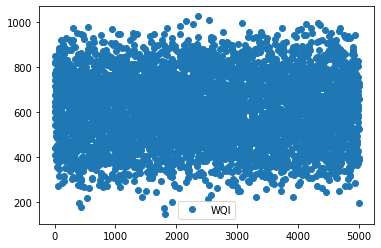

In [21]:
df_y.plot(style=["o"])

In [22]:
df_y[(df_y['WQI'] > 800.00)].count()

WQI    577
dtype: int64

In [26]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [27]:
X = df
Y = df_y

In [30]:
# define base model
def baseline_model():
# create model
	model = Sequential()
	model.add(Dense(19, input_dim=19, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

In [31]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [ ]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
# evaluate model with standardized dataset
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))


In [ ]:
def larger_model():
# create model
model = Sequential()
model.add(Dense(19, input_dim=19, kernel_initializer='normal', activation='relu'))
model.add(Dense(9, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

In [ ]:
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
return model
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))